# **Machine Learning**

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

- Last time we tried to write rules to capture what finger pixels looked like. 
- This didn't work so well. 
- This time we'll explore a different approach to identifying finger pixels in images, **machine learning**.
- The big idea here is that instead of coding up our own rules, perhaps we can **learn rules from our data**.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%pylab inline
import pickle, sys

sys.path.append('../util')
from data_handling import extractExamplesFromList, findUniqueRowsAndCount
from viz import showMatches, bw, rw, rwb
from data_handling import extractFeatures
from image import makeGrayScale

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Load data:
with open('../data/training_data.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
#Let's pick a few examples to experiment with:
exampleIndices = [0, 1, 2]

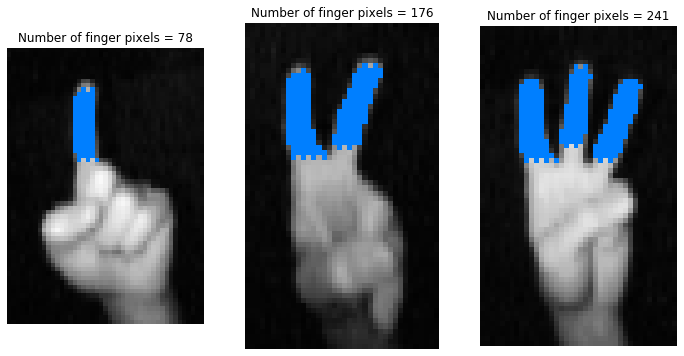

In [5]:
fig = figure(0, (12, 6))

for i in range(3):
    fig.add_subplot(1,3,i+1)
    imageDict = data[exampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    im = makeGrayScale(imageDict)
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im, interpolation = 'none')
    title('Number of finger pixels = ' + str(sum(y1==1)))
    axis('off')

In [6]:
examples = [data[index] for index in exampleIndices]
X, y = extractExamplesFromList(examples, whichImage = 'image1bit', dist = 4)

print(len(y), sum(y==1))

7867 495


In [7]:
7867-495

7372

- From our 3 images, we have 7867 pixels, and of these, 495 correspond to fingers.
- Remember we're sampling a 9x9 grid ("example") around each pixel, and using this information alone to determine if the pixel belongs to a finger.


![](../graphics/spacer_small.png)

## **Let's have a closer look at our examples**

- We have 7867 examples, but many are redundant, let's look at just the most common

In [10]:
uniqueExamples, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(X)
uniqueLabels = y[uniqueIndices]

sI = argsort(uniqueCounts)

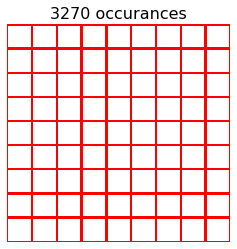

In [11]:
#Show most common example
fig = figure(0, (4,4))
example = uniqueExamples[0,:].reshape(9,9)
p = pcolor(flipud(example), cmap = rw,  linewidth =1.3, \
              color = 'r', vmin = 0, vmax = 1)
axis('off')
title(str(uniqueCounts[0]) + ' occurances', fontsize = 16);

## **Now let's look at 40 most common patterns**

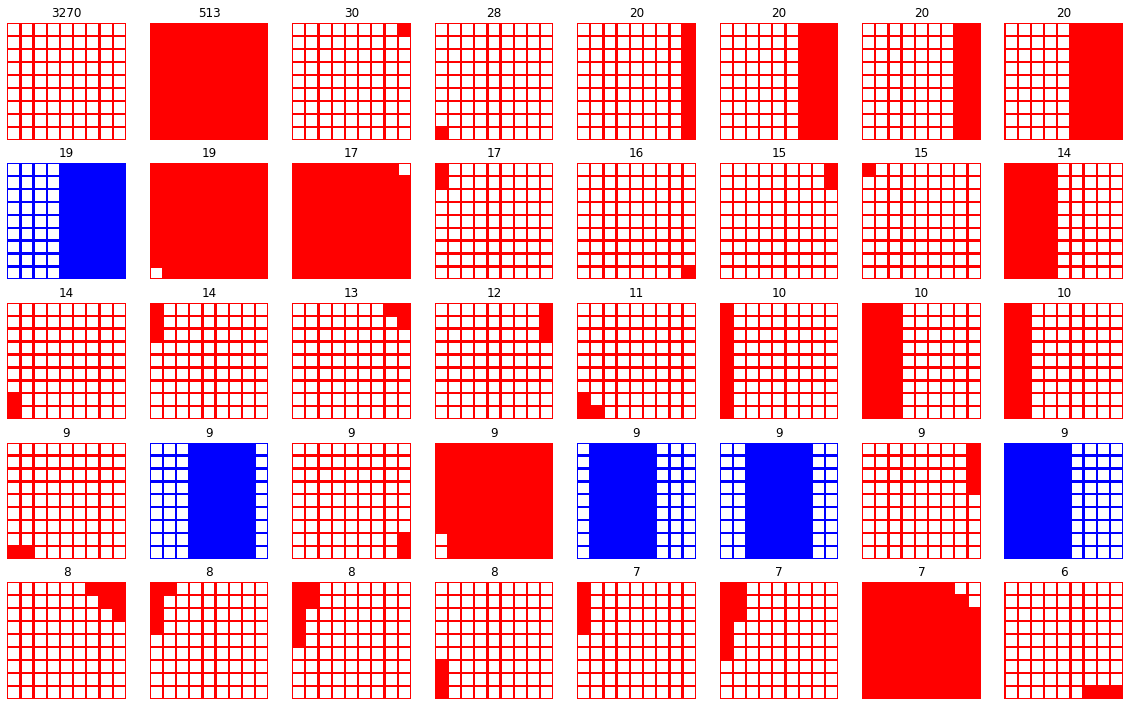

In [12]:
fig = figure(0, (20,15))

for i in range(40):
    index = sI[-1*(i+1)]
    example = uniqueExamples[index,:].reshape(9,9)
    
    if uniqueLabels[index]:
        colorMap = bw; mainColor = 'b'
    else: 
        colorMap = rw; mainColor = 'r'
    
    subplot(6,8,i+1)
    p = pcolor(flipud(example), cmap = colorMap,  linewidth =1.3, \
                  color = mainColor, vmin = 0, vmax = 1)
    axis('off')
    title(str(uniqueCounts[index]))

In [13]:
# How many unique examples do we have?
fingerExamples, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(X[y==1])
print(len(uniqueExamples), len(fingerExamples))

3090 413


We have 3090 unique examples, 413 of these examples show fingers.

## **Let's have a closer look at our 413 examples of fingers**

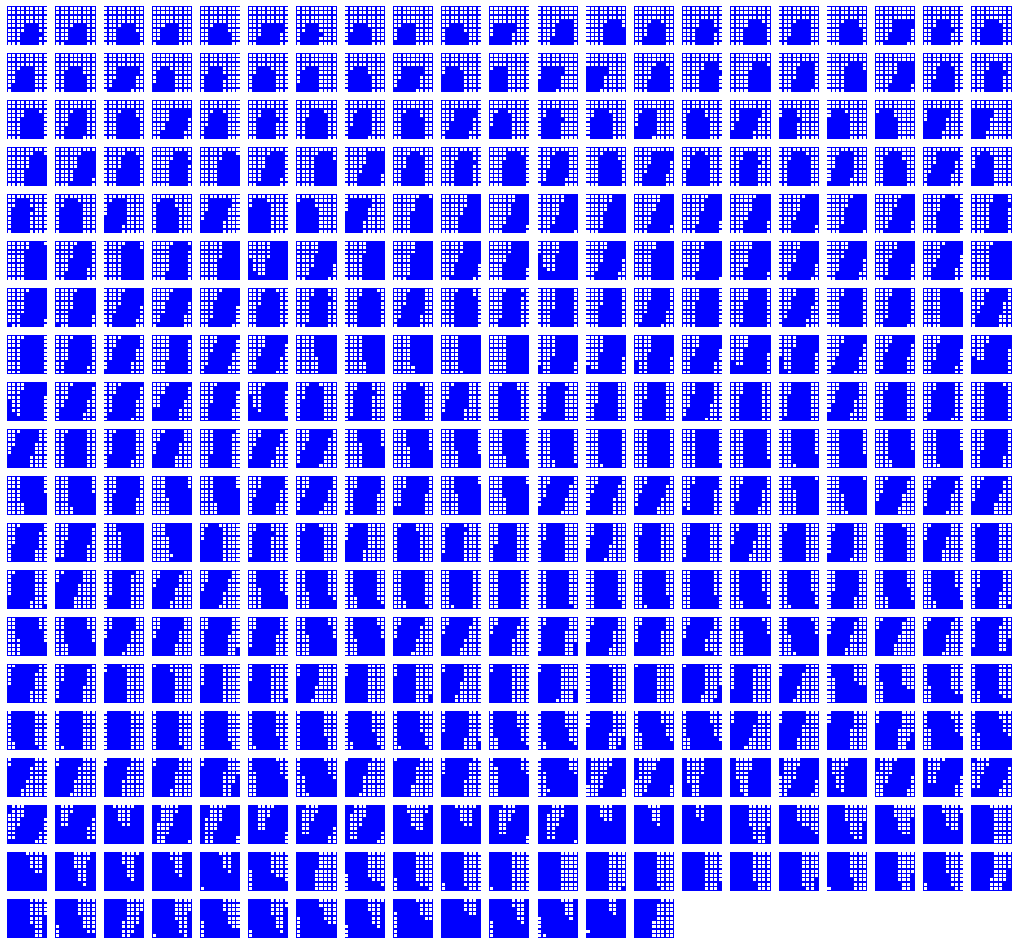

In [14]:
fig = figure(0, (18, 18))

for i in range(len(fingerExamples)):
    example = fingerExamples[i,:].reshape(9,9)
    
    subplot(21,21,i+1)
    p = pcolor(flipud(example), cmap = bw,  linewidth =.4, \
                  color = 'b', vmin = 0, vmax = 1)
    axis('off')

![](../graphics/spacer_small.png)

# **Our First Machine Learning Algorithm**

In [15]:
# Here it is, pretty exciting:
rules = fingerExamples.copy()

- We're simply letting each example of a finger in our dataset be its very own rule. 
- Now, before we test our algorithm, let's make sure we have a good mean of comparison to our earlier approaches.

---

![](../graphics/spacer_small.png)

![](../graphics/LTSQ1-01.png)

![](../graphics/spacer_small.png)

![](../graphics/spacer_small.png)

## **How is this so high?**
- Consider this challenge:

![](../graphics/spacer_small.png)

![](../graphics/LTSQ2-01.png)

![](../graphics/spacer_small.png)

---

- Ready for that one line of python?
- Remember that $y$ holds our "ground truth" labels for our examples $X$.

In [16]:
y

array([0., 0., 0., ..., 0., 0., 0.])

In [17]:
len(y)

7867

In [18]:
sum(y)

495.0

Since most of our examples are negative (non-fingers), one super simple option would be to just make a rule that says **"No pixels are finger pixels, ever"**, that is $\hat{y} = \mathbf{0}$.

In [19]:
yHat = np.zeros(len(y)) #One rule to rule them all!

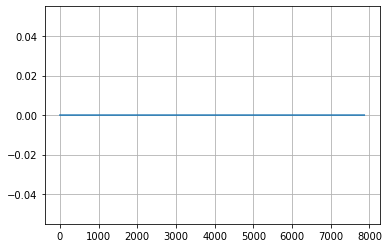

In [20]:
plot(yHat)
grid(1)

- Pretty exciting plot!
- Now, let's prove that our rule is 94% accurate. Ready?

In [21]:
num_errors = sum(abs(y-yHat))

In [22]:
num_errors

495.0

- Ok, so we miss all the finger pixels...but...

In [23]:
num_examples = len(y)
num_correct = num_examples - num_errors

In [24]:
print(num_errors, num_correct, num_examples)

495.0 7372.0 7867


In [25]:
accuracy = num_correct/num_examples

In [26]:
accuracy

0.9370789373331638

- Boom! 94% accurate, as promised.
- Now, if this seems a bit hacky, it should!
- This leads us to a big point for today - **the accuracy of a classifier does not tell the whole story**.
- To really see what's going on here we need some [better metrics](https://en.wikipedia.org/wiki/Confusion_matrix). 
- We'll use a popular pair of metrics, **precision and recall**.

![](../graphics/precision_recall_perceptual.png)

- Let's put these in our own words.
- For this finger/non-finger example, what does precision mean? What does recall mean?
- What would a high/low recall mean?
- What would a high/low precision mean?
- Next time someone tells you what the accuracy of their classifier is - don't take it at face value, ask for recall and precision.

---

- Summary of performance thus far:

![](../graphics/table_one-01.png)

- As you can see, precision and recall give us a much better view into our algorithm's performance.
- Note the yellow, red, and green pixels in our images - what does each color represent?

![](../graphics/spacer_small.png)

## **Now, we're finally ready to try some machine learning (!)**

- Remember the strategy we discussed trying here - just "letting our examples be rules". Let's make sure this makes sense. Here's our data:

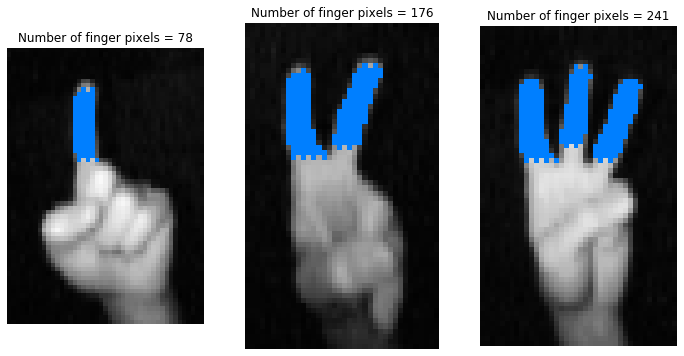

In [25]:
fig = figure(0, (12, 6))

for i in range(3):
    fig.add_subplot(1,3,i+1)
    imageDict = data[exampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    im = makeGrayScale(imageDict)
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im, interpolation = 'none')
    title('Number of finger pixels = ' + str(sum(y1==1)))
    axis('off')

Now, remember that we're working with binary data to make things simpler, let's quickly look at this data:

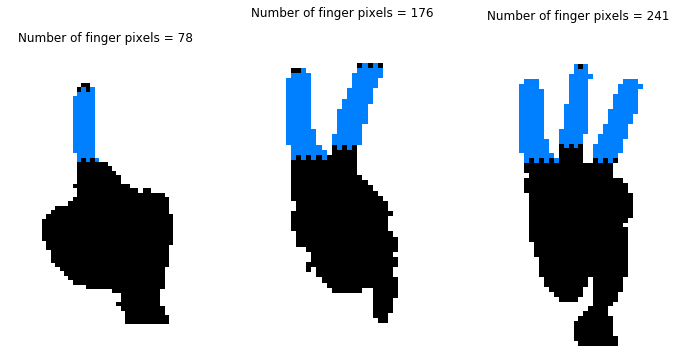

In [27]:
fig = figure(0, (12, 6))

for i in range(3):
    fig.add_subplot(1,3,i+1)
    imageDict = data[exampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    image_one_bit = imageDict['image1bit'][imageDict['boxEdges'][2]:imageDict['boxEdges'][3], \
                                       imageDict['boxEdges'][0]:imageDict['boxEdges'][1]]

    im = np.ones((image_one_bit.shape[0], image_one_bit.shape[1], 3))
    im[image_one_bit, :] = 0
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im, interpolation = 'none')
    title('Number of finger pixels = ' + str(sum(y1==1)))
    axis('off')

And finally, from these 3 examples, when we sample a 9x9 grid around each pixel, we end up with **413 unique examples of finger pixels**:

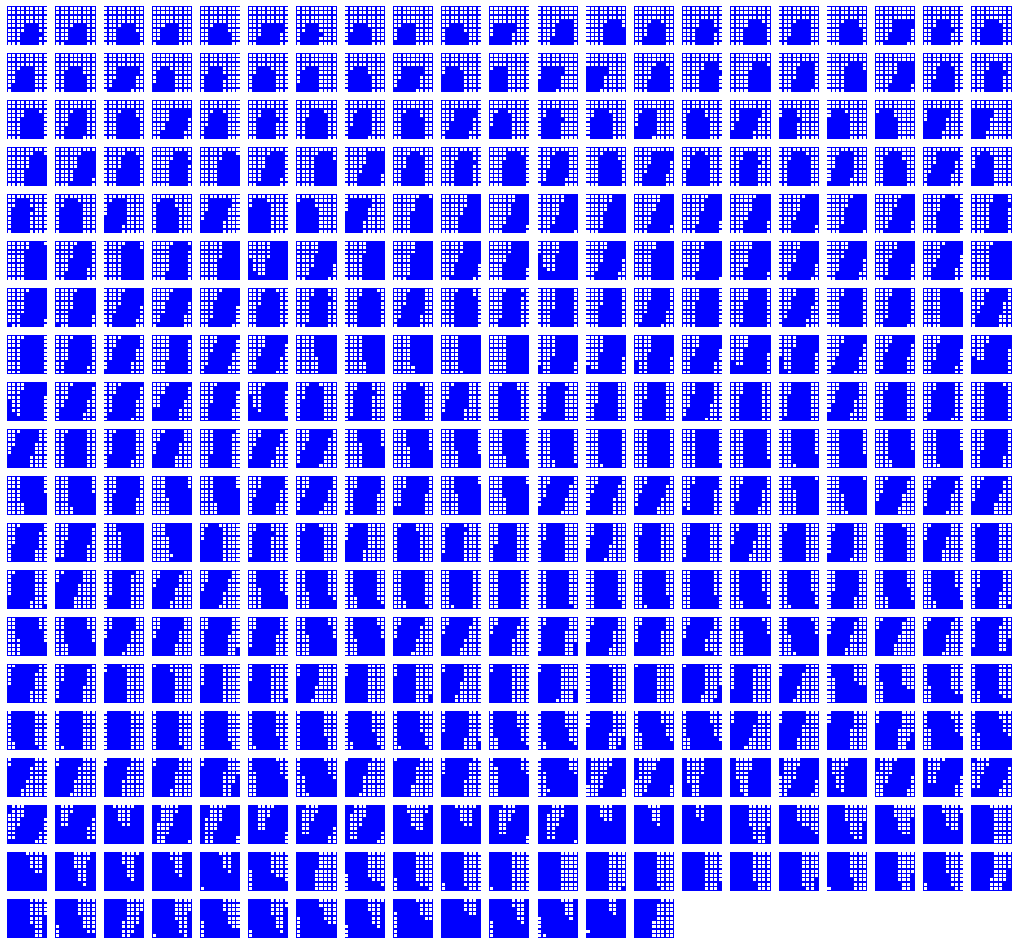

In [28]:
fig = figure(0, (18, 18))

for i in range(len(fingerExamples)):
    example = fingerExamples[i,:].reshape(9,9)
    
    subplot(21,21,i+1)
    p = pcolor(flipud(example), cmap = bw,  linewidth =.4, \
                  color = 'b', vmin = 0, vmax = 1)
    axis('off')

In [29]:
# Here's our first machine learning algorithm, pretty exciting. 
rules = fingerExamples.copy()

In [30]:
rules.shape

(413, 81)

- So, whenever we see an example like the 413 ones above, we'll call it a finger. 
- Predictions on how our algorithm will perform?

![](../graphics/spacer_small.png)

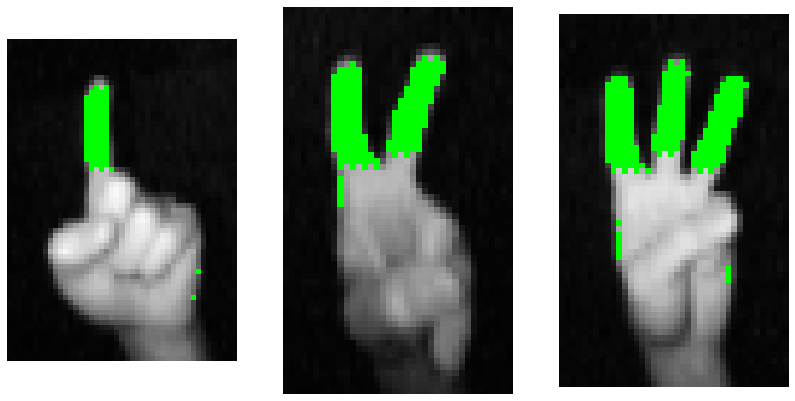

In [31]:
fig = figure(0, (14, 8))
showMatches(rules = rules, exampleIndices = exampleIndices, data=data, fig=fig, verbose = False)

That looks pretty good, right? Let's measure performance:

In [32]:
# Search for matches to rules
matchingIndices = np.array([], dtype = 'int')
for rule in rules:
    difference = X - rule
    mI = np.where(~difference.any(axis=1))[0]
    matchingIndices = np.concatenate((matchingIndices, mI))

#Make yHat vector, tells us which pixels our rules predict to be fingers.
yHat = np.zeros(X.shape[0])
yHat[matchingIndices] = 1

#Count up False Negatives, False Positives, True Positives, and True Negatives
FN =  np.sum(np.logical_and(y==1, yHat==0))
FP =  np.sum(np.logical_and(y==0, yHat==1))
TP = np.sum(np.logical_and(y==1, yHat==1))
TN = np.sum(np.logical_and(y==0, yHat==0))
    
#make confusion matrix:
confusionMatrix = np.array([[TP, FN], [FP, TN]])

print(confusionMatrix)

[[ 495    0]
 [  16 7356]]


![](../graphics/LTSQ3-01.png)

---

![](../graphics/spacer_small.png)

- Pretty good, right!?
- Let's compare our performance with our earlier approaches:

![](../graphics/table_two-01.png)

- Alright, so we win, right? 
- Machine learning done :)
- Now, if this seems a little suspicious to you - good! 
- We've missed what is possibly the most important point in all of Machine Learning - a simple, but critical point that will come up again and again in Machine Learning.
- Now, before you watch the next video to figure out what it is, or just ask your friends what's going on here - take a minute to reflect. What did we miss here? What's wrong with this approach? Our performance is really really high - **what's the problem?**